n=  51  crit=  0.259  type-I=0.048  power=0.269
n=  56  crit=  0.244  type-I=0.051  power=0.650
n=  61  crit=  0.223  type-I=0.055  power=0.876
n=  66  crit=  0.194  type-I=0.061  power=0.945
n=  71  crit=  0.152  type-I=0.027  power=0.973
n=  76  crit=  0.120  type-I=0.064  power=0.991
n=  81  crit=  0.066  type-I=0.061  power=0.998
n=  86  crit=  0.009  type-I=0.056  power=0.998
n=  91  crit= -0.068  type-I=0.043  power=0.999
n=  96  crit= -0.120  type-I=0.057  power=1.000


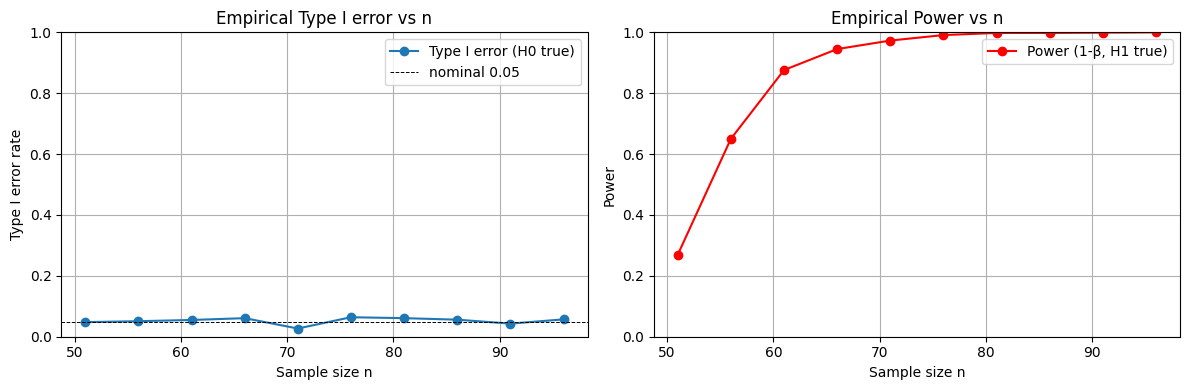

In [9]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# ------------------------
# Settings
# ------------------------
d = 50                # base number of features (large for Gaussian approx)
sigma2 = 1.0
theta_s = 1.5         # effect size under H1
alpha = 0.05

# simulation sizes
n_calib = 2000        # sims to calibrate null per n (must be reasonably large)
n_eval = 1000         # sims to estimate type-I / power per n
n_values = np.arange(51, 100, 5)

# helper: log pdf under Gaussian approx for Q = RSS/n
def log_gaussian_pdf(x, mu, var):
    return -0.5 * np.log(2 * np.pi * var) - (x - mu)**2 / (2 * var)

def compute_logLR_for_one(n, use_sensitive):
    """Simulate one dataset and return logL_d - logL_d1 (logLR)."""
    X_d = np.random.randn(n, d)
    sensitive = np.random.randn(n, 1)
    X_d1 = np.hstack([X_d, sensitive])

    theta_d = np.random.randn(d)
    theta_d1 = np.hstack([theta_d, theta_s])

    eps = np.random.randn(n) * np.sqrt(sigma2)
    if use_sensitive:
        y = X_d1 @ theta_d1 + eps
    else:
        y = X_d @ theta_d + eps

    # Fit OLS without sensitive attribute
    theta_hat_d = np.linalg.lstsq(X_d, y, rcond=None)[0]
    residuals_d = y - X_d @ theta_hat_d
    Q_obs = (residuals_d.T @ residuals_d) / n

    # Gaussian approx params
    mu_d = sigma2 * d / n
    var_d = 2 * sigma2**2 * d / n**2
    mu_d1 = sigma2 * (d + 1) / n
    var_d1 = 2 * sigma2**2 * (d + 1) / n**2

    logL_d = log_gaussian_pdf(Q_obs, mu_d, var_d)
    logL_d1 = log_gaussian_pdf(Q_obs, mu_d1, var_d1)
    logLR = logL_d - logL_d1
    return float(logLR)

# ------------------------
# Calibration + evaluation
# ------------------------
type1_list = []
power_list = []

for n in n_values:
    # --- calibrate null distribution of logLR ---
    null_logLRs = np.empty(n_calib)
    for i in range(n_calib):
        null_logLRs[i] = compute_logLR_for_one(n, use_sensitive=False)
    crit = np.quantile(null_logLRs, alpha)   # reject H0 when logLR <= crit

    # sanity: estimate empirical type-I with fresh sims
    null_test_logLRs = np.empty(n_eval)
    for i in range(n_eval):
        null_test_logLRs[i] = compute_logLR_for_one(n, use_sensitive=False)
    type1_emp = np.mean(null_test_logLRs <= crit)

    # estimate power with fresh sims under H1
    alt_logLRs = np.empty(n_eval)
    for i in range(n_eval):
        alt_logLRs[i] = compute_logLR_for_one(n, use_sensitive=True)
    power_emp = np.mean(alt_logLRs <= crit)

    type1_list.append(type1_emp)
    power_list.append(power_emp)
    print(f"n={n:4d}  crit={crit:7.3f}  type-I={type1_emp:.3f}  power={power_emp:.3f}")

# Plot Type I error and Power side by side
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(n_values, type1_list, marker='o', label='Type I error (H0 true)')
plt.axhline(0.05, color='k', linestyle='--', linewidth=0.7, label='nominal 0.05')
plt.ylim(0, 1)
plt.xlabel('Sample size $n$',  fontsize=25)
plt.ylabel('Type I error',  fontsize=25)
plt.title('Type I error vs $n$',  fontsize=25)
plt.grid(True)
plt.legend(fontsize=15)

plt.subplot(1,2,2)
plt.plot(n_values, power_list, marker='o', color='r', label='Power (1-β, H1 true)')
plt.ylim(0, 1)
plt.xlabel('Sample size $n$', fontsize=25)
plt.ylabel('Power',  fontsize=25)
plt.title('Empirical Power vs $n$',  fontsize=25)
plt.grid(True)
plt.legend(loc='lower right',fontsize=15)  # <--- only this line

plt.savefig("basic.pdf", format="pdf", bbox_inches='tight')  
plt.show()

In [21]:
n = 50
d1 = 5
d2 = 10
alpha = 0.05
n_sim = 10000  # number of simulations for estimating threshold and power

# --- Step 1: Estimate threshold under H0 ---
logLR_H0_sim = []
for _ in range(n_sim):
    x = np.random.chisquare(d1, size=n)
    lr = log_likelihood_chisq(x, d2) - log_likelihood_chisq(x, d1)
    logLR_H0_sim.append(lr)

threshold = np.quantile(logLR_H0_sim, 1-alpha)

# --- Step 2: Estimate type I error ---
type1_count = 0
for _ in range(n_sim):
    x = np.random.chisquare(d1, size=n)
    lr = log_likelihood_chisq(x, d2) - log_likelihood_chisq(x, d1)
    if lr > threshold:
        type1_count += 1
type1_error = type1_count / n_sim

# --- Step 3: Estimate power ---
power_count = 0
for _ in range(n_sim):
    x = np.random.chisquare(d2, size=n)
    lr = log_likelihood_chisq(x, d2) - log_likelihood_chisq(x, d1)
    if lr > threshold:
        power_count += 1
power = power_count / n_sim

print("Type I error:", type1_error)
print("Power:", power)

Type I error: 0.0514
Power: 1.0


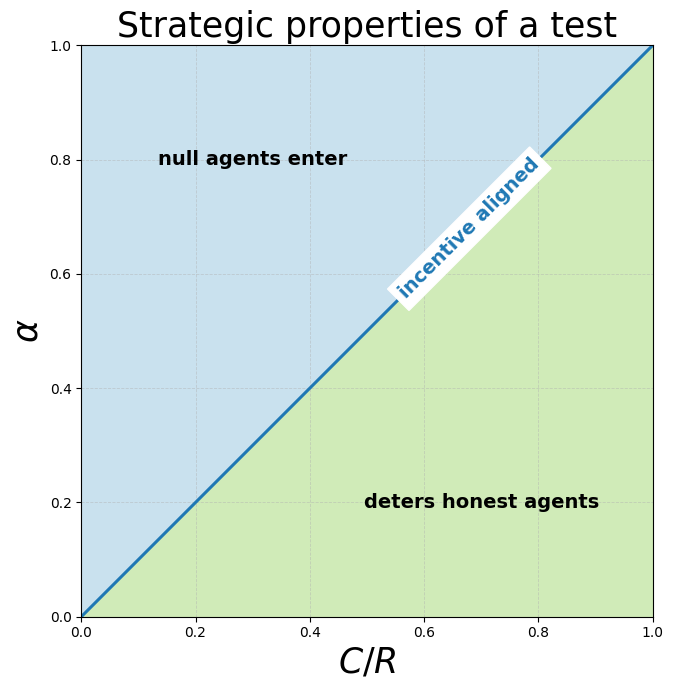

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# grid
x = np.linspace(0, 1, 400)
y = np.linspace(0, 1, 400)
X, Y = np.meshgrid(x, y)

# figure
fig, ax = plt.subplots(figsize=(7,7))

# Regions: above y=x and below y=x
above = Y > X
below = Y < X

# Fill regions with a colorblind-friendly palette
ax.contourf(X, Y, above, levels=[-0.5, 0.5, 1.5], colors=["#b2df8a","#a6cee3"], alpha=0.6)
# Draw the separating line y=x
ax.plot(x, x, linewidth=2.2, linestyle='-', color='#1f78b4')

# Annotations in regions
ax.text(0.3, 0.8, "null agents enter", fontsize=14, weight='bold', va='center', ha='center')
ax.text(0.7, 0.2, "deters honest agents", fontsize=14, weight='bold', va='center', ha='center')

# Rotated annotation along y=x (45°)
ax.text(0.55, 0.55, "incentive aligned", fontsize=14, weight='bold',
        rotation=45, color='#1f78b4', ha='left', va='bottom', backgroundcolor='white')

# Axes labels and limits
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.xlabel('$C/R$', fontsize=25)
plt.ylabel(r"$\alpha$", fontsize=25)
ax.set_title('Strategic properties of a test', fontsize=25)

# Grid and aspect
ax.grid(True, linewidth=0.6, linestyle='--', alpha=0.5)
ax.set_aspect('equal', adjustable='box')
plt.savefig("types_of_contract.pdf", format="pdf", bbox_inches='tight')  
plt.tight_layout()
plt.show()

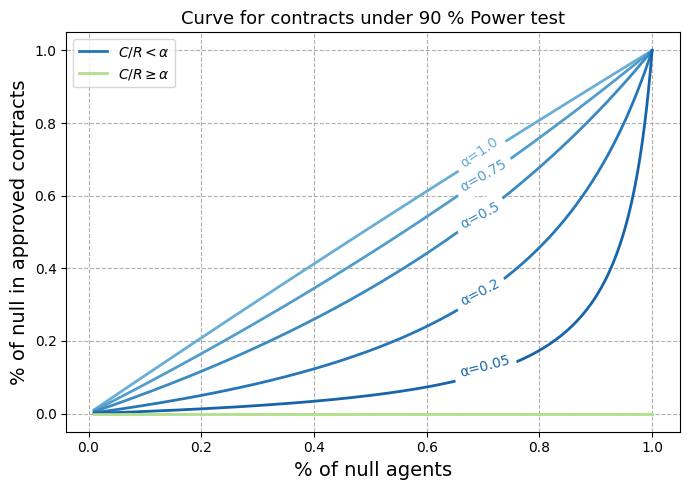

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# K ranges between 0 and 1
K = np.linspace(0.01, 1, 300)

# Different alpha values
alphas = [1.0, 0.75, 0.5, 0.2, 0.05]
rotations= [35, 30, 28, 28, 15]
# Color map for shades of blue
colors = plt.cm.Blues(np.linspace(0.5, 0.8, len(alphas)))

# Plot
fig, ax = plt.subplots(figsize=(7,5))

for i, alpha in enumerate(alphas):
    y = (alpha * K) / ((1-K)*0.95 + alpha*K)
    line, = ax.plot(K, y, color=colors[i], linewidth=2)
    # Annotate alpha on the line
    idx = int(len(K) * 0.65)  # choose a point at 70% along x-axis
    ax.text(K[idx], y[idx]+0.01, f'α={alpha}', color=colors[i],  rotation=rotations[i],backgroundcolor='white', fontsize=10)

# y_incentivized line
ax.plot(K, 0*K, color='#b2df8a', linewidth=2, label=r'$C/R \geq \alpha$')

# Labels and title
ax.set_xlabel(r'% of null agents', fontsize=14)
ax.set_ylabel(r'% of null in approved contracts', fontsize=14)
ax.set_title(r'Strategic behavior of agents under 90 % Power test', fontsize=13)

# Grid and legend
ax.grid(True, linestyle='--')

# Create a custom legend for the blue lines
from matplotlib.lines import Line2D
blue_line = Line2D([0], [0], color='#1f78b4', linewidth=2, label=r'$C/R < \alpha$')
ax.legend(handles=[blue_line, ax.lines[-1]])

plt.tight_layout()
plt.show()

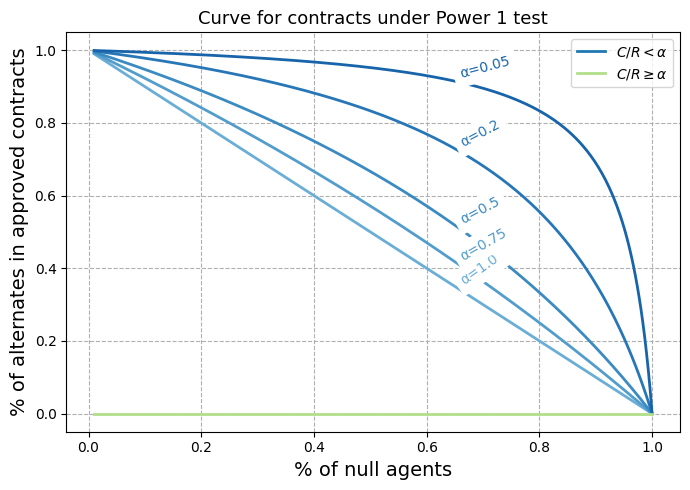

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# K ranges between 0 and 1
K = np.linspace(0.01, 1, 300)

# Different alpha values
alphas = [1.0, 0.75, 0.5, 0.2, 0.05]
rotations= [35, 30, 28, 28, 15]
# Color map for shades of blue
colors = plt.cm.Blues(np.linspace(0.5, 0.8, len(alphas)))

# Plot
fig, ax = plt.subplots(figsize=(7,5))

for i, alpha in enumerate(alphas):
    y = (1-K) / (1 + (alpha - 1) * K)
    line, = ax.plot(K, y, color=colors[i], linewidth=2)
    # Annotate alpha on the line
    idx = int(len(K) * 0.65)  # choose a point at 70% along x-axis
    ax.text(K[idx], y[idx]+0.01, f'α={alpha}', color=colors[i],  rotation=rotations[i],backgroundcolor='white', fontsize=10)

# y_incentivized line
ax.plot(K, 0*K, color='#b2df8a', linewidth=2, label=r'$C/R \geq \alpha$')

# Labels and title
ax.set_xlabel(r'% of null agents', fontsize=14)
ax.set_ylabel(r'% of alternates in approved contracts', fontsize=14)
ax.set_title(r'Curve for contracts under Power 1 test', fontsize=13)

# Grid and legend
ax.grid(True, linestyle='--')

# Create a custom legend for the blue lines
from matplotlib.lines import Line2D
blue_line = Line2D([0], [0], color='#1f78b4', linewidth=2, label=r'$C/R < \alpha$')
ax.legend(handles=[blue_line, ax.lines[-1]])

plt.tight_layout()
plt.show()